# Import libs

In [122]:
# Import some stuff
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl

from datetime import datetime
from dateutil.parser import parse
import pandas as pd


from pandas.io.json import json_normalize
from PIL import Image
from wordcloud import STOPWORDS, WordCloud

# SET A SEED
seed = 320


# We will need this at some point....
import geopandas as gp

In [11]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

In [12]:
# load .env variable
base_dir = 'D:\Documentos\GitHub\CityBlender'
dotenv_file = os.path.join(base_dir, '.env')


if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

In [13]:
# create a new MongoDB Client
db_client = MongoClient(str(db_uri))

# If it's ok it should return a 1.0
db_client.london.command("serverStatus")['ok']

1.0

In [14]:
# choose a database to connect to (.london)
db_london = db_client.london

# choose a collection
db_london_events = db_london['events']
db_london_artist = db_london['artists']

In [15]:
# lookup all the documents in a collection
db_london_events.find()

## EOD

In [16]:
events = pd.DataFrame(list(db_london_events.find({})))

In [17]:
events.columns

Index(['_id', 'artists', 'date', 'datetime', 'datetime_source', 'foursquare',
       'id', 'lastfm', 'location', 'name', 'popularity', 'spotify', 'time',
       'type', 'url', 'venue'],
      dtype='object')

### For instance in the first row there are 3 events

In [18]:
# Put this in the date fomrat
events['date'] = [(datetime.strptime(events['date'][x], '%Y-%m-%d')) for x in range(len(events['date']))]

# Convert the dates into day name
events['date_name'] = [(events['date'][x].strftime("%A")) for x in range(len(events['date']))]

# Lat & Long
events['lat'] = [(events['location'][x]['lat']) for x in range(len(events['location']))]
events['lng'] = [(events['location'][x]['lng']) for x in range(len(events['location']))]

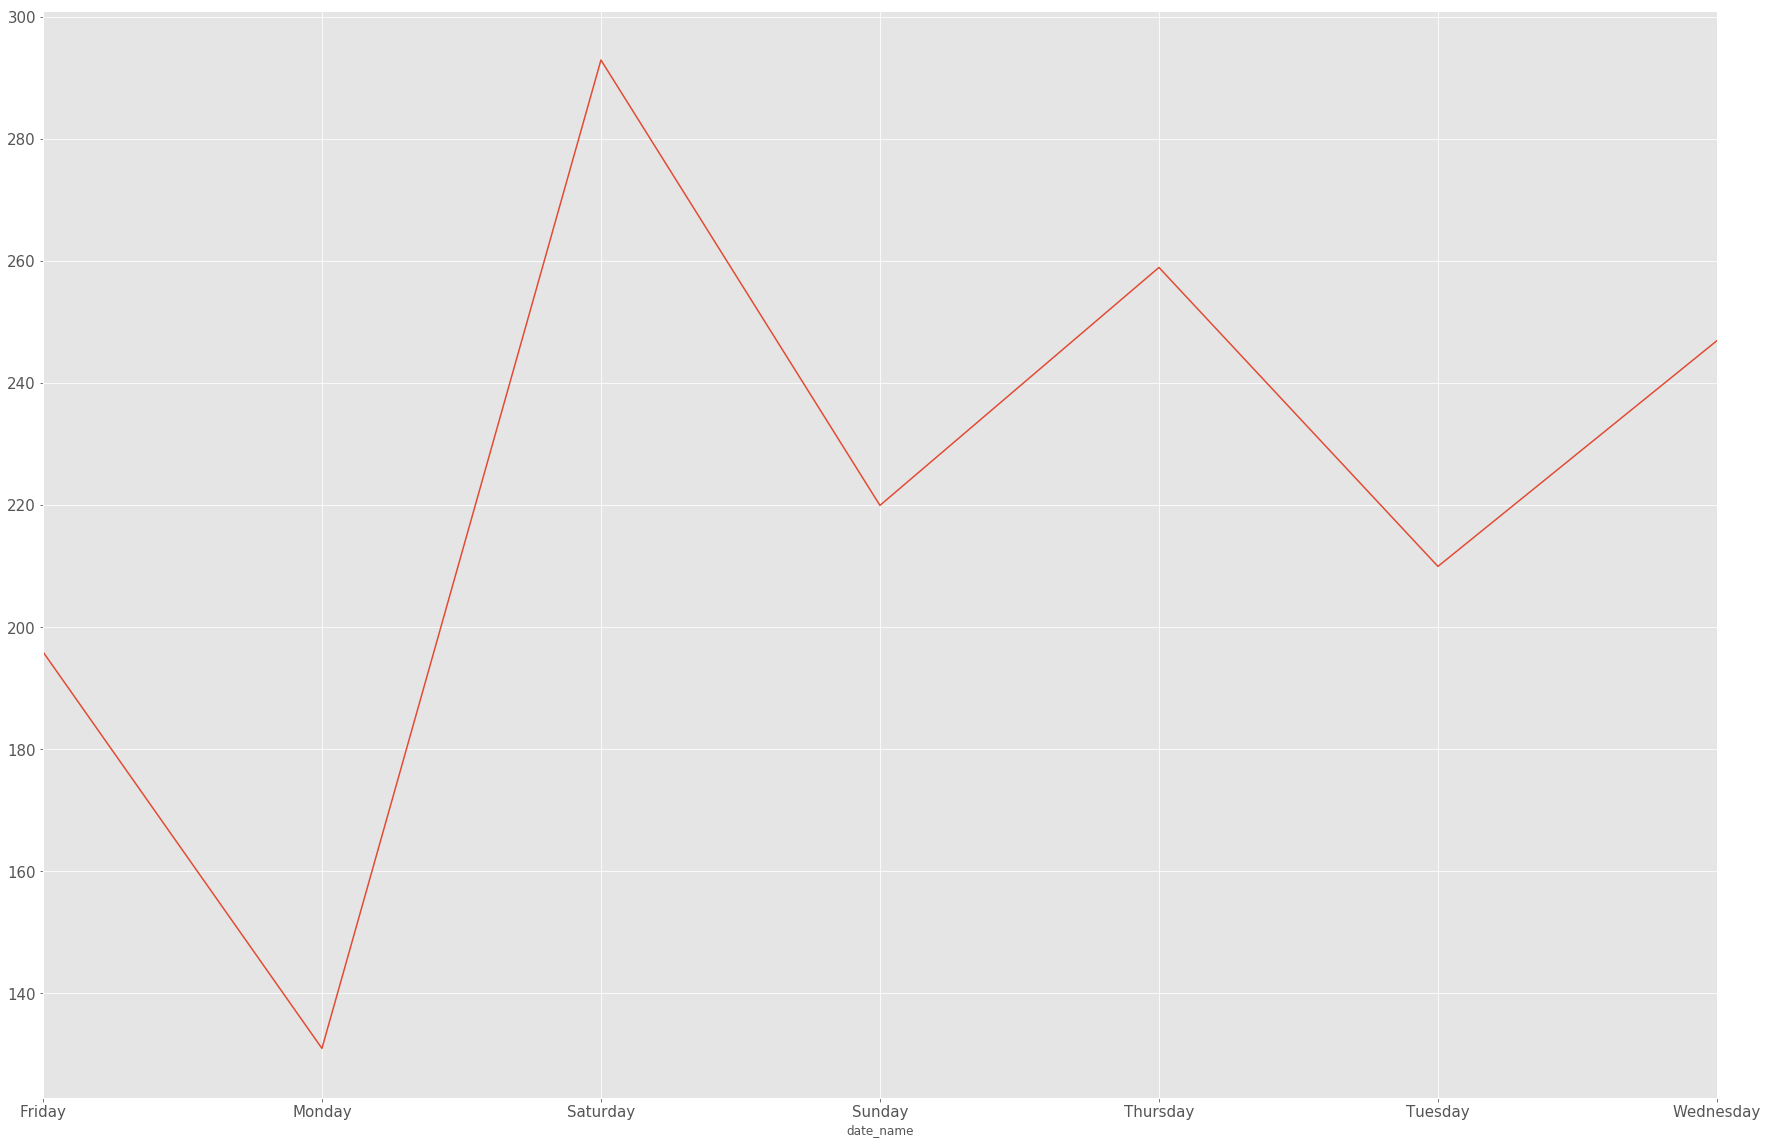

In [54]:
events.groupby('date_name').count()['_id'].plot()

## Spotify

In [29]:
type(events['spotify'][0])

dict

In [240]:
len(events['spotify'][0])

66

In [30]:
for key in events['spotify'][0]:
  print(key)

genres
popularity
popularity_median
popularity_min
popularity_max
popularity_pvariance
followers
followers_sum
danceability
danceability_median
danceability_min
danceability_max
danceability_pvariance
energy
energy_median
energy_min
energy_max
enery_pvariance
key
key_mode
key_min
key_max
loudness
loudness_median
loudness_min
loudness_max
loudness_pvariance
mode
mode_mode
speechiness
speechiness_median
speechines_min
speechines_max
speechines_pvariance
acousticness
acousticness_median
acousticness_min
acousticness_max
acousticness_pvariance
instrumentalness
instrumentalness_median
instrumentalness_min
instrumentalness_max
instrumentalness_pvariance
liveness
liveness_median
liveness_min
liveness_max
liveness_pvariance
valence
valence_median
valence_min
valence_max
valence_pvariance
tempo
tempo_median
tempo_min
tempo_max
tempo_pvariance
duration_ms
duration_ms_mean
duration_ms_min
duration_ms_max
duration_ms_pvariance
time_signature
time_signature_mode


In [90]:
list1 = [
    'popularity_pvariance',
    'danceability_pvariance',
    'enery_pvariance',
    'speechines_pvariance',
    'acousticness_pvariance',
    'instrumentalness_pvariance',
    'liveness_pvariance',
    'valence_pvariance',
    'duration_ms_pvariance',
    'tempo_pvariance',]

In [259]:
list_of_bars = [
    'popularity_median',
    'followers_sum',
    'danceability_median',
    'energy_median',
    'key_mode',
    'loudness_median',
    'mode_mode',
    'speechiness_median',
    'acousticness_median',
    'instrumentalness_median',
    'liveness_median',
    'valence_median',
    'duration_ms_mean',
    'time_signature_mode']

In [260]:
def make_vars(db = events, dictionary = 'spotify', var = 'popularity_median'):
    lista_nueva = []
    # Make this for the desired variable
    for i in range(len(db[dictionary])):
        # If there is nothing in the spotify dictionary, make Nan value
        if type(db[dictionary][i]) == float:
            lista_nueva.append(np.nan)

        else:
            # print(db[dictionary][i][var])
            lista_nueva.append(db[dictionary][i][var])
            
    # Integrate all the stuff
    db[var] =   lista_nueva      


In [261]:
for i in list_of_bars:
    # print(i)
    make_vars(db = events, dictionary = 'spotify', var = i)

In [98]:
def make_boxes( db = events, var_x = "date_name", var_y = 'popularity_median'):
    plt.rcParams['figure.figsize'] = 12, 8
    axis_font = {'fontname':'Arial', 'size':'25'}

    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels


    sns.boxplot(x=var_x, y = var_y, data=db)

    plt.xlabel(var_x, **axis_font)
    plt.ylabel(var_y, **axis_font)
    

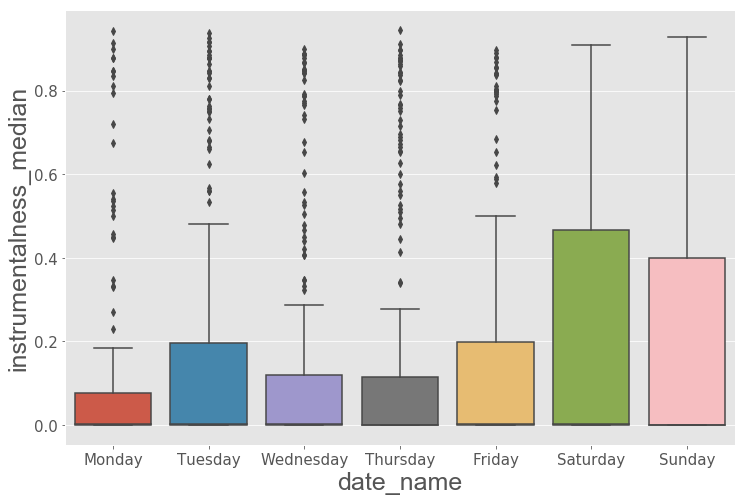

In [106]:
make_boxes(var_y = 'instrumentalness_median')

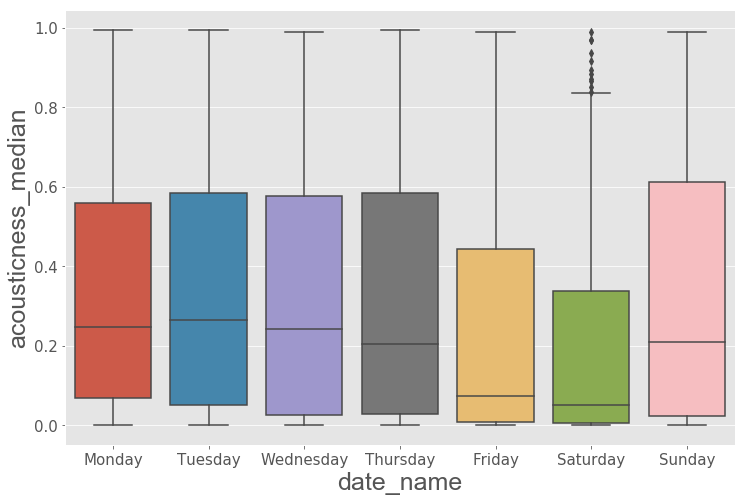

In [105]:
make_boxes(var_y = 'acousticness_median')

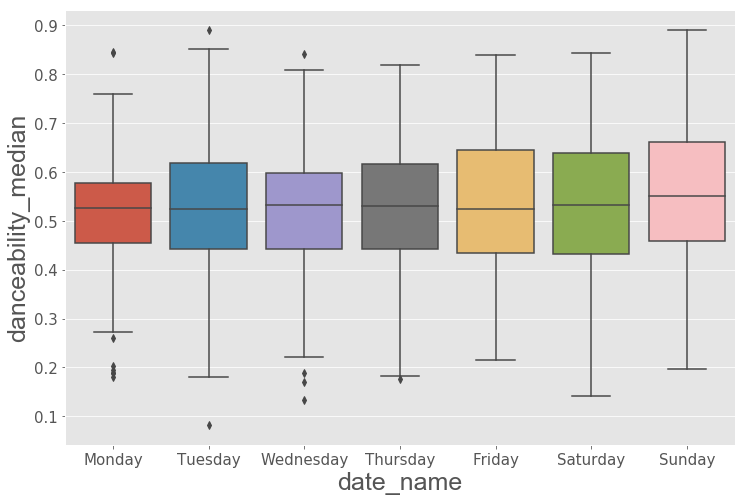

In [101]:
make_boxes(var_y = 'danceability_median')

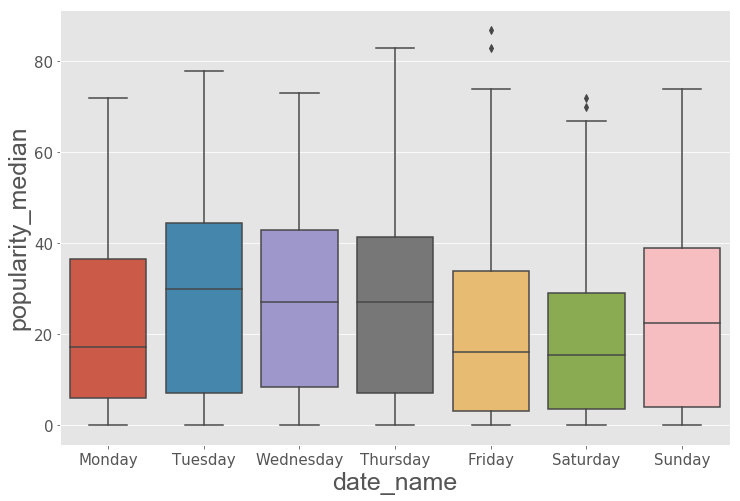

In [102]:
make_boxes(var_y = 'popularity_median')

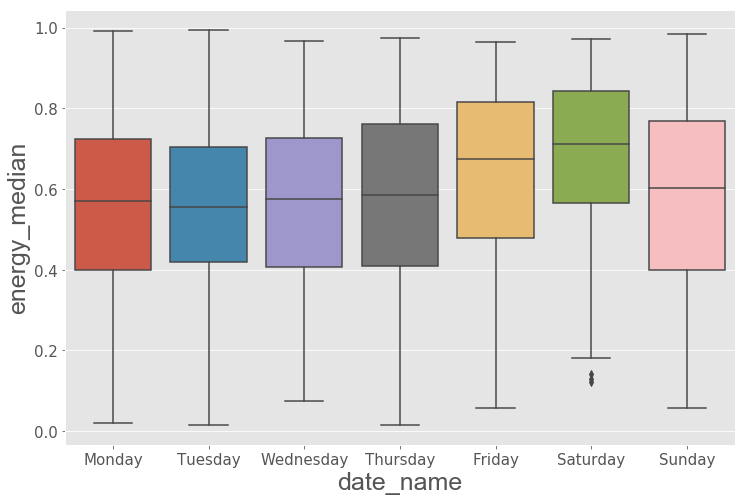

In [104]:
make_boxes(var_y = 'energy_median')

In [31]:
def plot_a_scatter(db = events, x = 'tempo_median', y = 'acousticness_median'):

    for_plot = pd.DataFrame()
    list_of_x = []
    list_of_y = []
    
    for i in range(len(db['spotify'])):
        if type(db['spotify'][i]) != float:
            list_of_x.extend(db['spotify'][i][x])

    for i in range(len(db['spotify'])):
        if type(db['spotify'][i]) != float:
            list_of_y.extend(db['spotify'][i][y])
            
    for_plot[x] = list_of_x
    for_plot[y] = list_of_y
    
    plt.rcParams['figure.figsize'] = 30, 20
    plt.scatter(for_plot[x], for_plot[y])

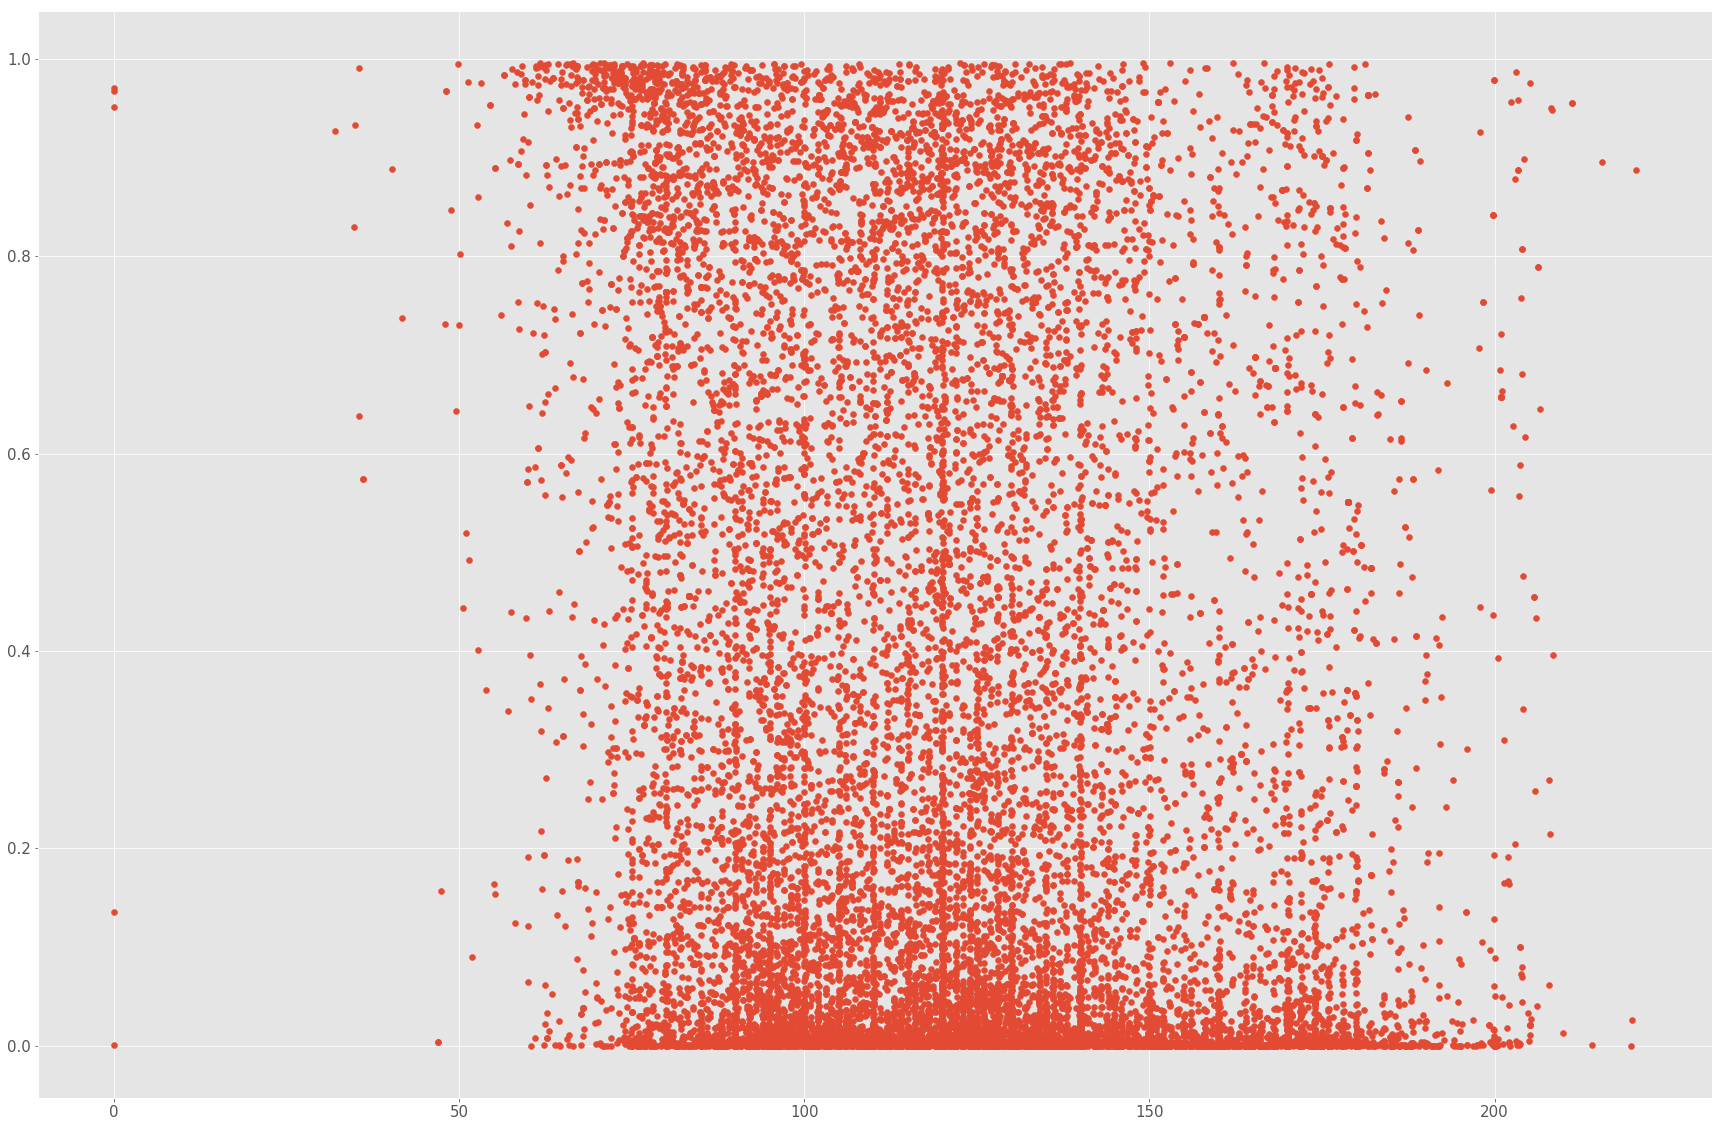

In [32]:
plot_a_scatter(db = events, x = 'tempo', y = 'acousticness')

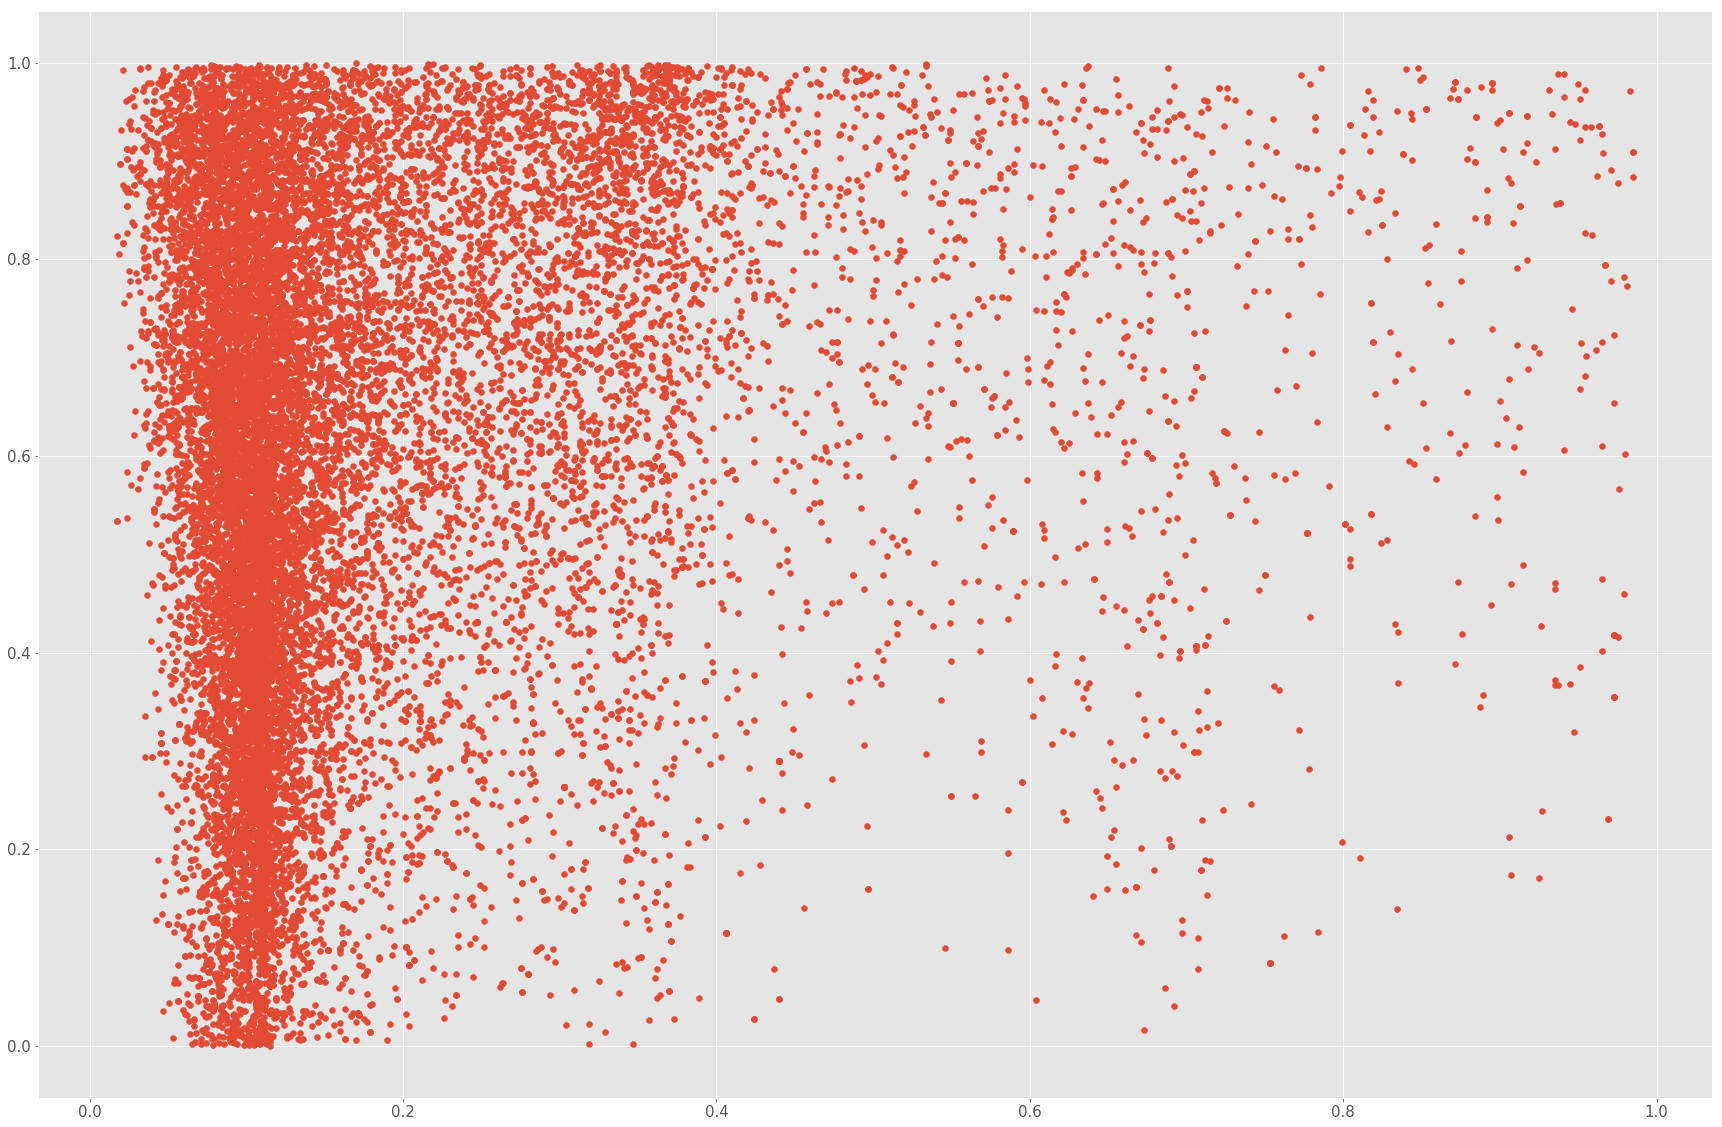

In [33]:
plot_a_scatter(db = events, x = 'liveness', y = 'energy')

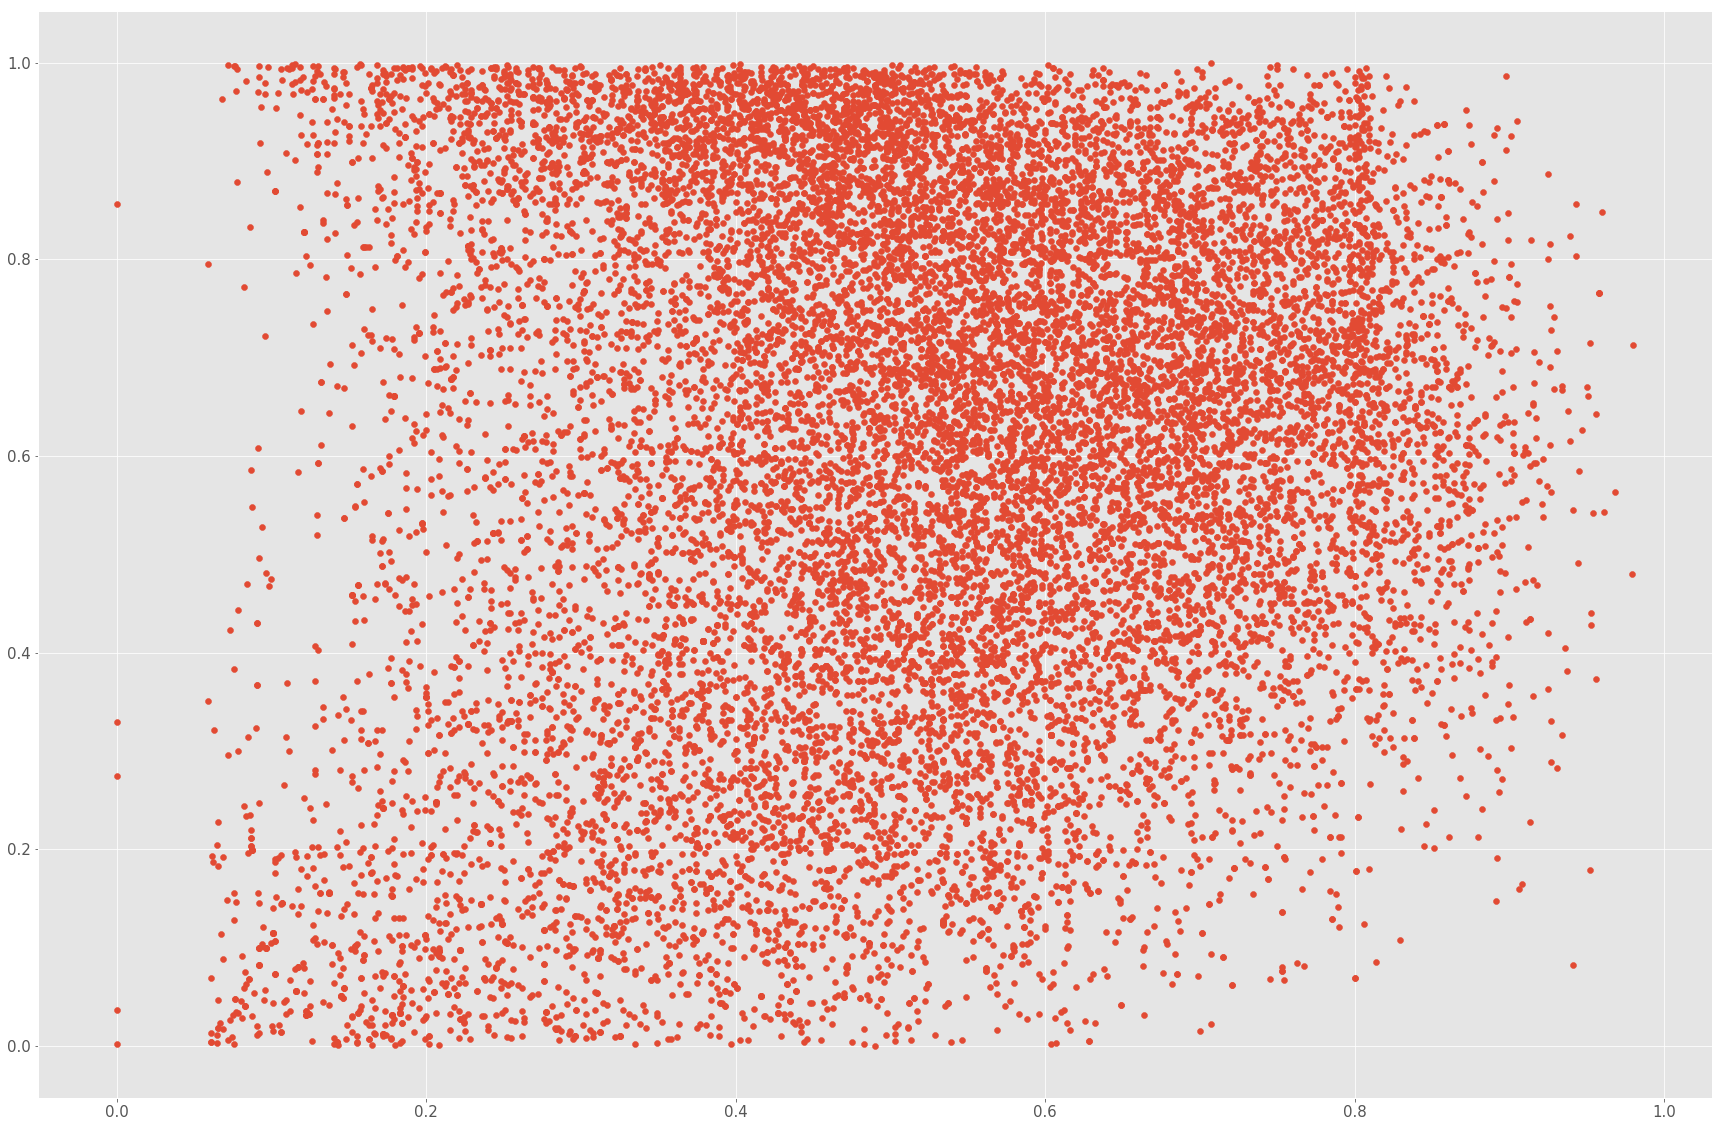

In [34]:
plot_a_scatter(db = events, x = 'danceability', y = 'energy')

## Genere - What to do with missing values

In [146]:
def lista_generos(db = events, lib = 'spotify', var = 'genres'):
    list_of_strings = []

    for i in range(len(db[lib])):
        if type(db[lib][i]) != float:
            list_of_strings.extend(db[lib][i][var])
            
    return(list_of_strings)    


In [147]:
list_of_generes = lista_generos(db = events, lib = 'spotify', var = 'genres')

In [36]:
events['spotify'][2]['genres']

['bow pop',
 'chamber pop',
 'compositional ambient',
 'focus',
 'icelandic classical',
 'icelandic pop',
 'neoclassical',
 'new tribe']

## Word cloud

In [148]:
len(list_of_generes)

2639

In [149]:
words = list_of_generes

### For some reason this code stop working.... something wrong with pillow module

In [154]:
def make_a_Wcloud(lista = list_of_generes, mask = "London_mask2.png", n_words=200):
    london_mask = np.array(Image.open(mask))
    stopwords = set(STOPWORDS)
    data = lista

    wordcloud = WordCloud(width=600, height=200,
                              background_color='black',
                              stopwords=stopwords,
                              max_words=n_words,
                              max_font_size=80,
                              mask=london_mask,
                              random_state=42
                             ).generate(str((data)))



    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

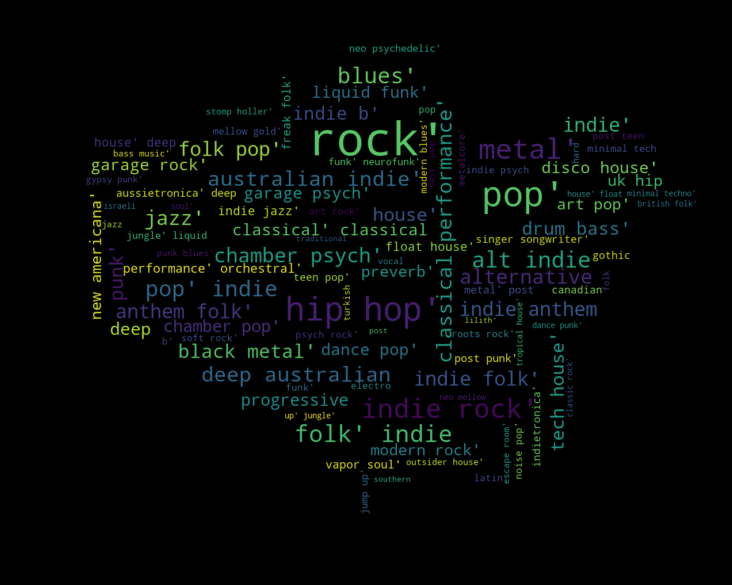

In [155]:
make_a_Wcloud(n_words = 100)

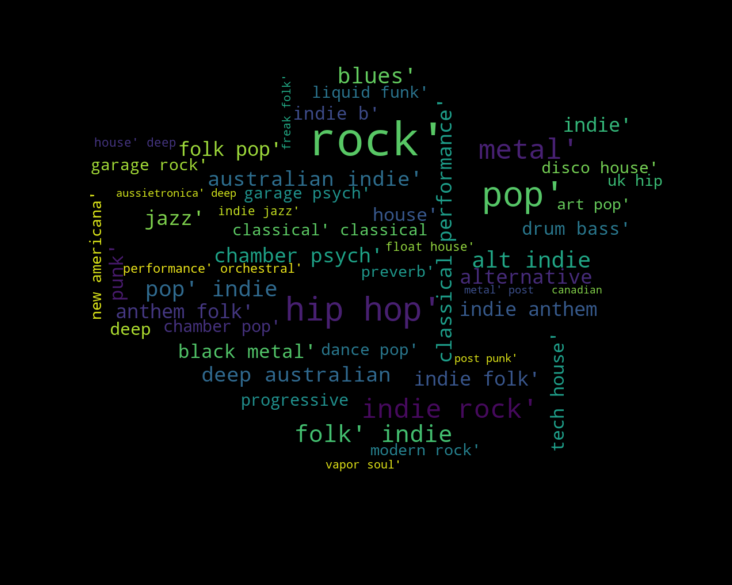

In [156]:
make_a_Wcloud(n_words = 50)

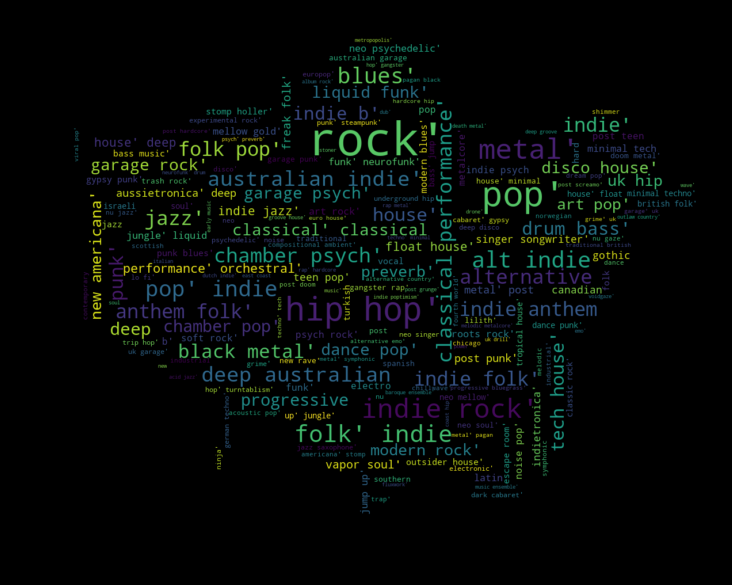

In [157]:
make_a_Wcloud(n_words = 200)

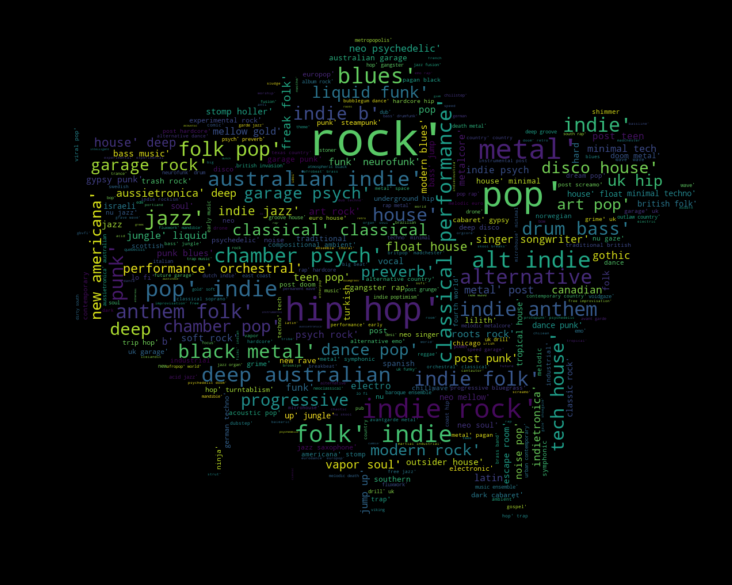

In [159]:
make_a_Wcloud(n_words = 350)

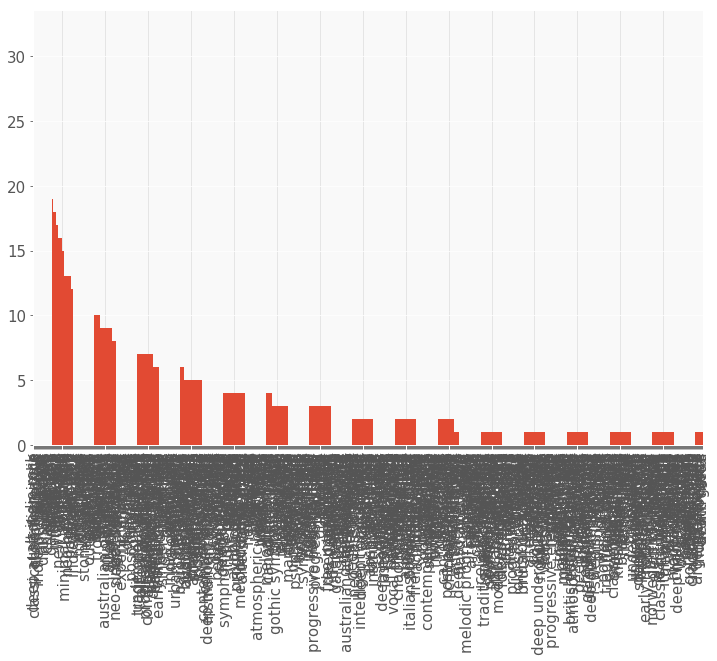

In [129]:
pd.Series(words).value_counts().plot('bar')

## Spotify vars

In [40]:
def plot_distributions(db = events, var = 'acousticness_median'):
    list_of_var = []

    for i in range(len(db['spotify'])):
        if type(db['spotify'][i]) != float:
            list_of_var.append(db['spotify'][i][var])
    
    
    plt.hist(list_of_var)

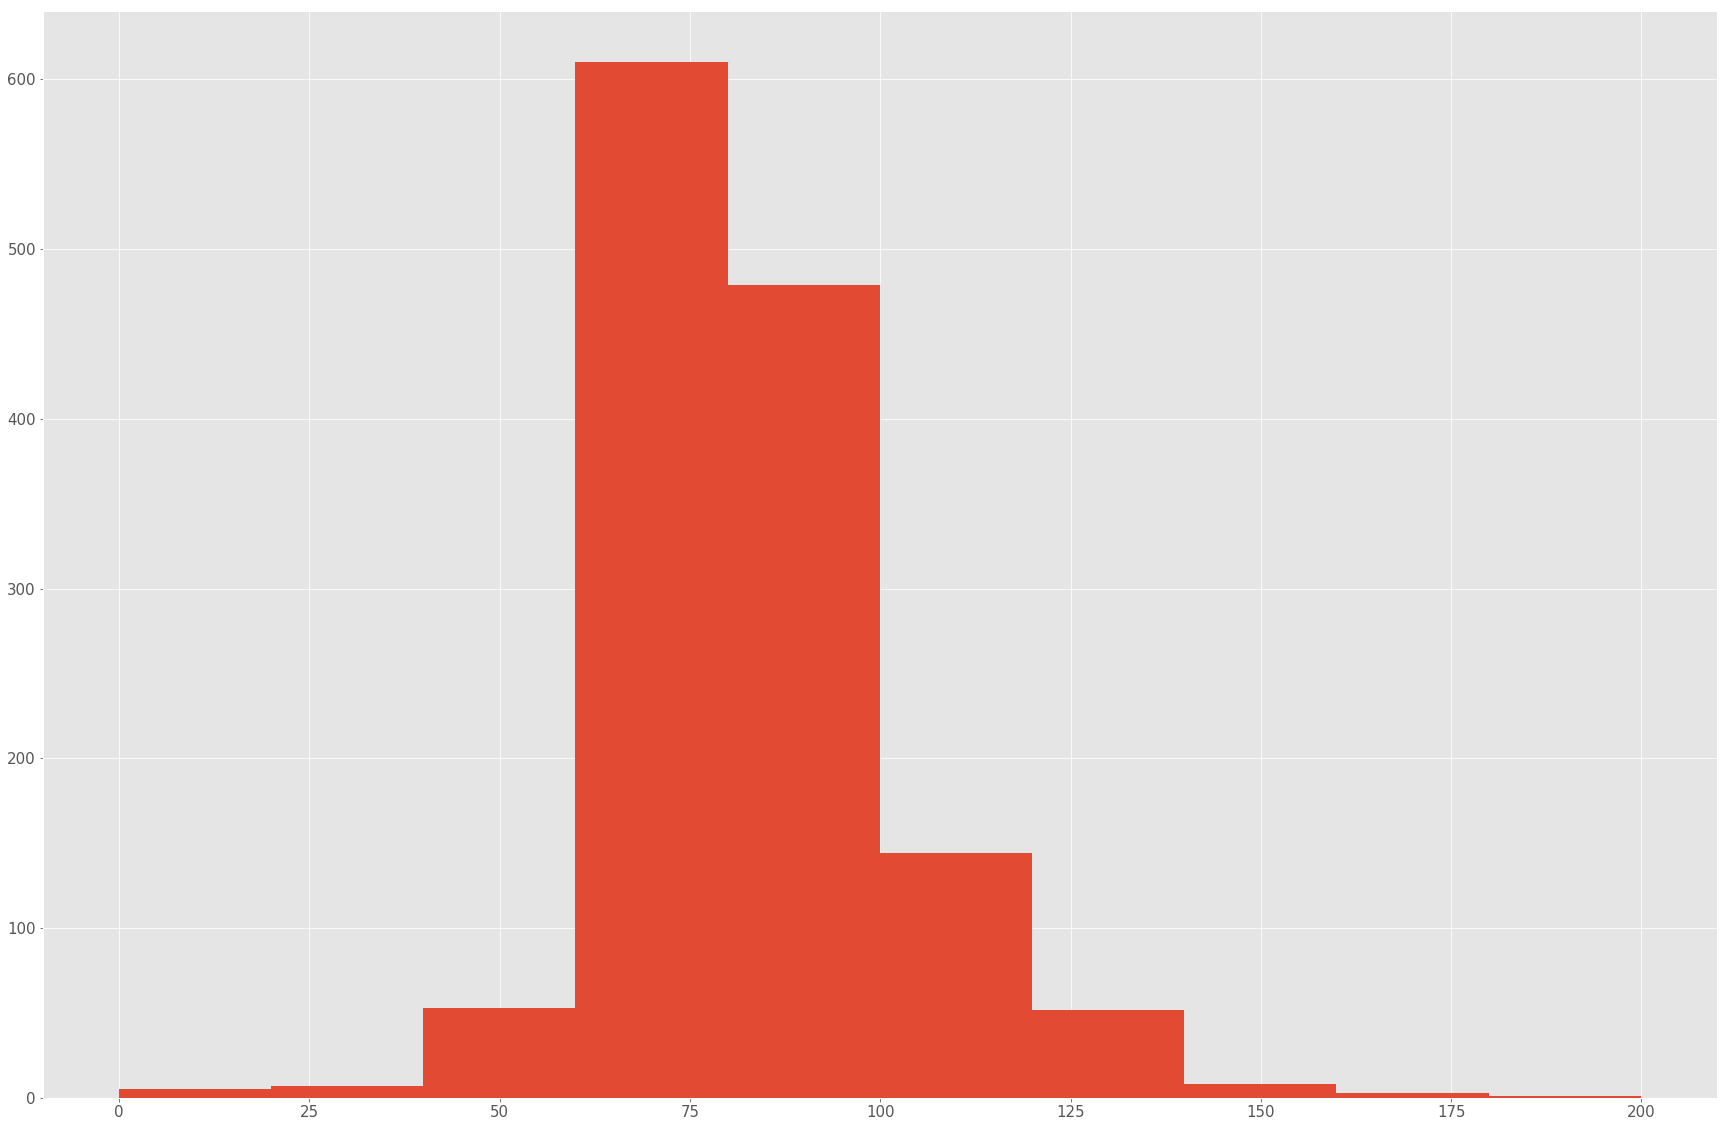

In [41]:
plot_distributions(events, var = 'tempo_min')

In [42]:
list_of_acousticness = []

for i in range(len(events['spotify'])):
    if type(events['spotify'][i]) != float:
        list_of_acousticness.append(events['spotify'][i]['acousticness_median'])
    

(array([563., 148., 115.,  91.,  67.,  77.,  71.,  79.,  78.,  73.]),
 array([2.56000000e-06, 9.95023040e-02, 1.99002048e-01, 2.98501792e-01,
        3.98001536e-01, 4.97501280e-01, 5.97001024e-01, 6.96500768e-01,
        7.96000512e-01, 8.95500256e-01, 9.95000000e-01]),
 <a list of 10 Patch objects>)

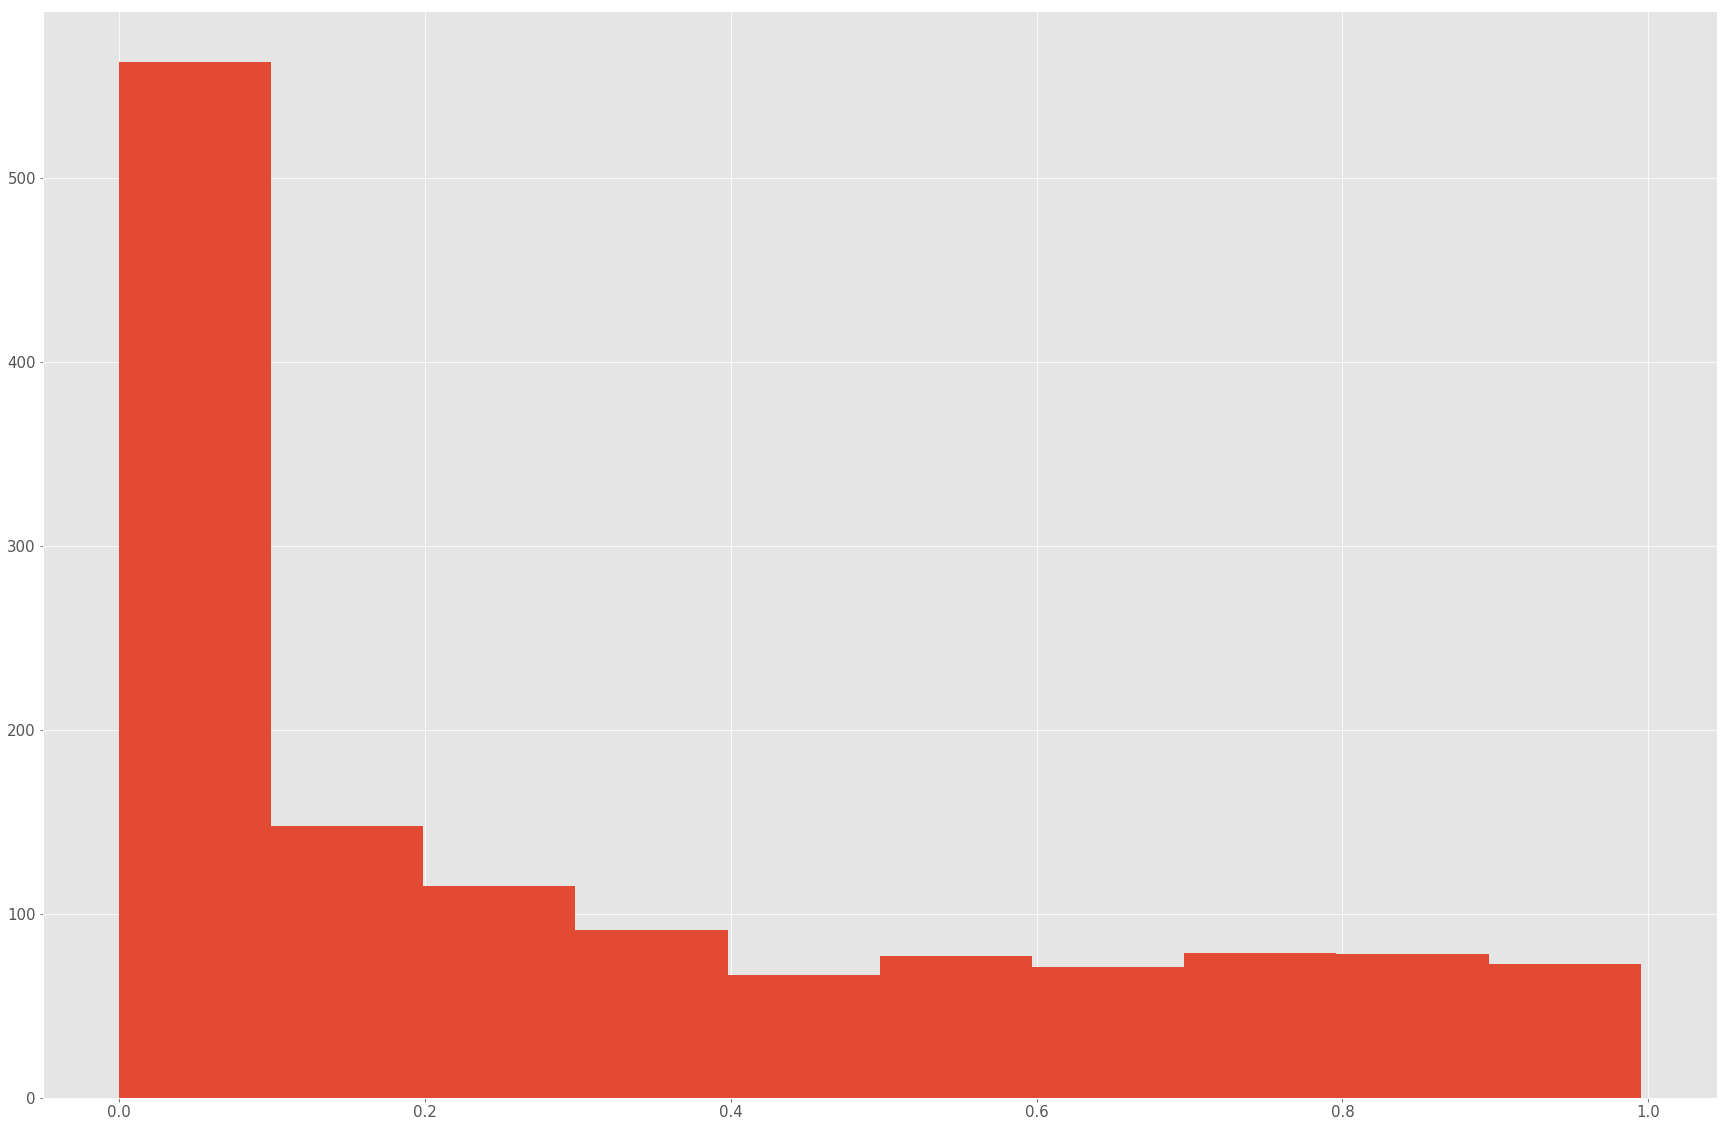

In [43]:
plt.hist(list_of_acousticness)

In [44]:
list_of_tempo = []
list_of_dance =[]

db = events

for i in range(len(db['spotify'])):
        if type(db['spotify'][i]) != float:
            list_of_tempo.append(db['spotify'][i]['energy_median'])
            
for i in range(len(db['spotify'])):
        if type(db['spotify'][i]) != float:
            list_of_dance.append(db['spotify'][i]['popularity_median'])            

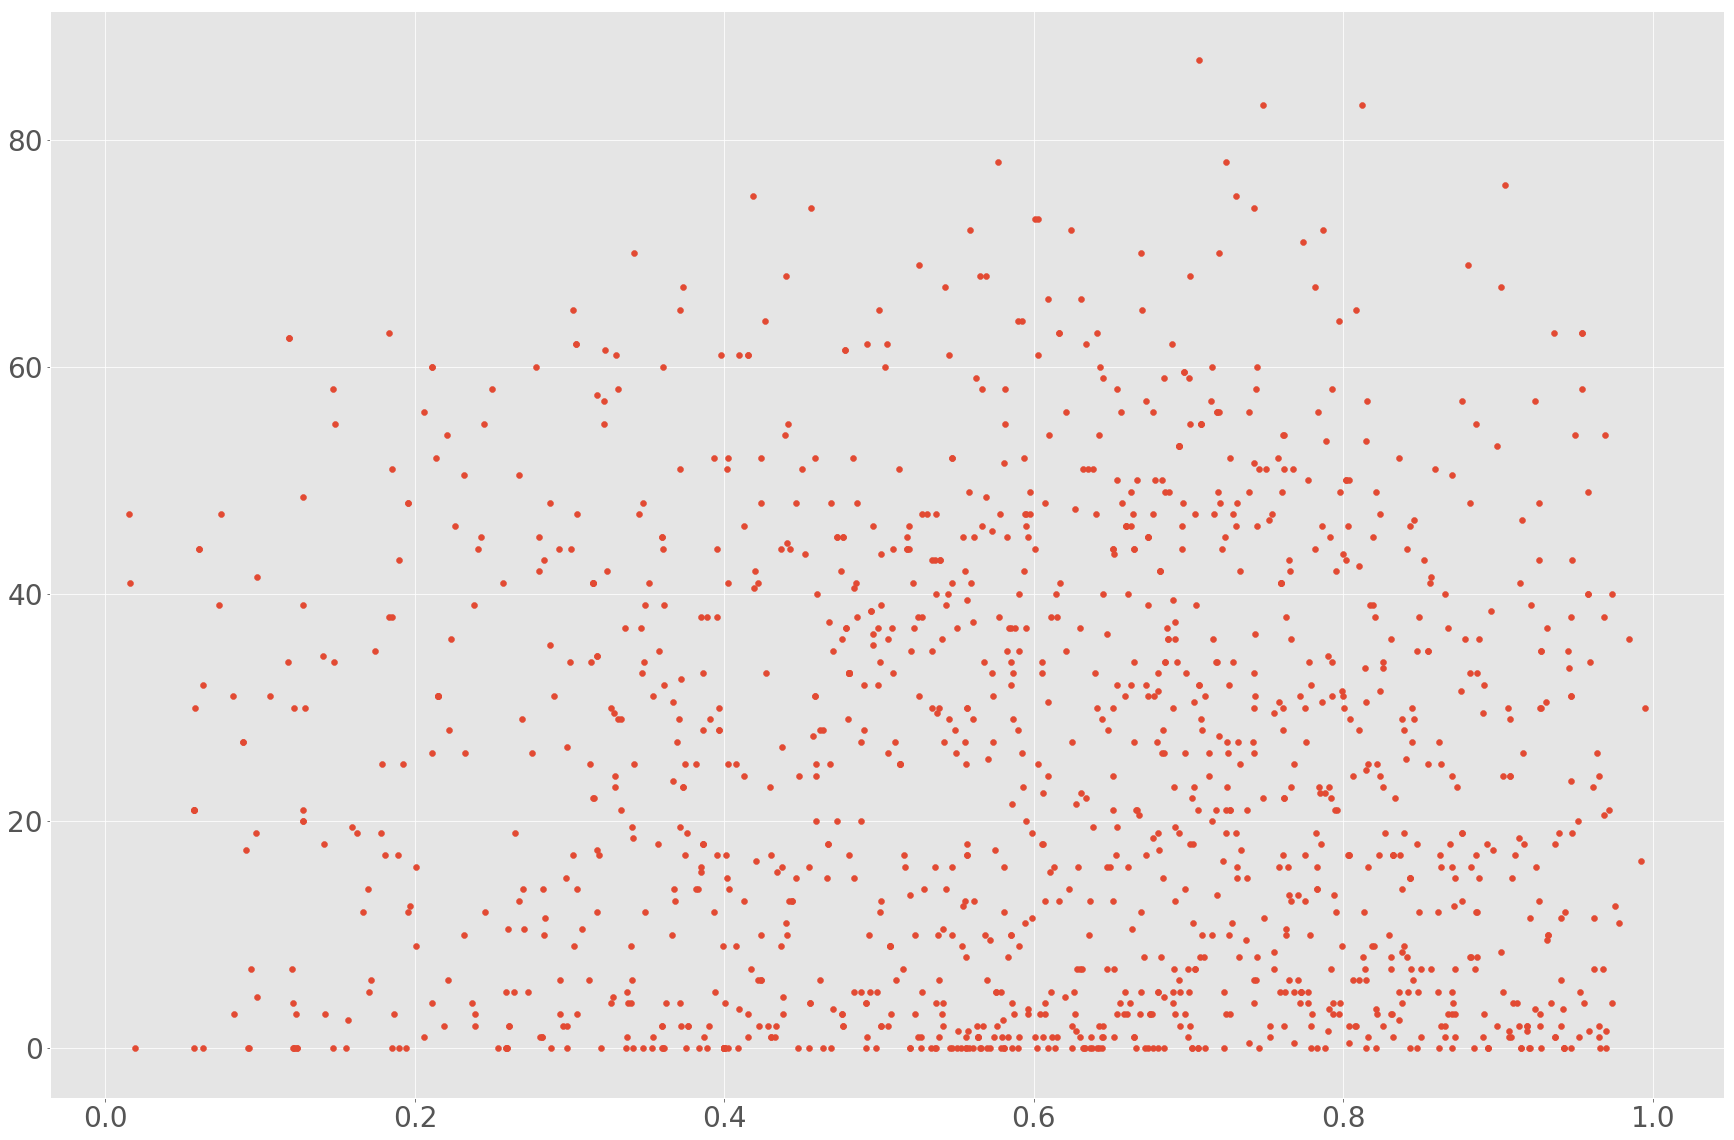

In [45]:
plt.scatter(list_of_tempo, list_of_dance)


plt.tick_params(labelsize=28)

## Last.fm

In [108]:
events['lastfm'][0]

{'listeners': [412072, 57, 192843],
 'listeners_sum': 604972,
 'playcount': [21290352, 958, 3674367],
 'playcount_sum': 24965677,
 'tags': ['seen live',
  'folk',
  'singer-songwriter',
  'acoustic',
  'british',
  'indie',
  'folk punk',
  'punk',
  'folk rock',
  'rock',
  'seen live',
  'indie',
  'acoustic',
  'singer-songwriter',
  'british',
  'alternative',
  'folktronica',
  'indie pop',
  'folk',
  'emo']}

In [163]:
last_fm_list = ['listeners_sum',
               'playcount_sum']

In [164]:
for i in last_fm_list:
    # print(i)
    make_vars(db = events, dictionary = 'lastfm', var = i)

(0, 5000000)

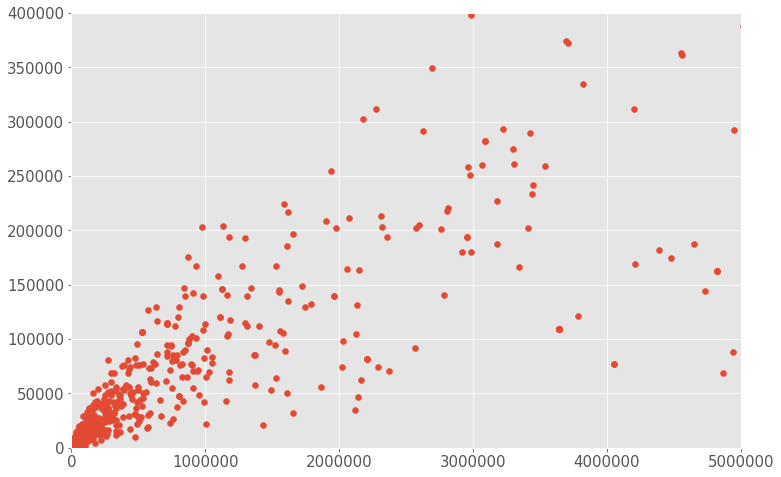

In [173]:
plt.scatter(db['playcount_sum'], db['listeners_sum'])
plt.ylim(0,400000)
plt.xlim(0,5000000)

(0, 750000)

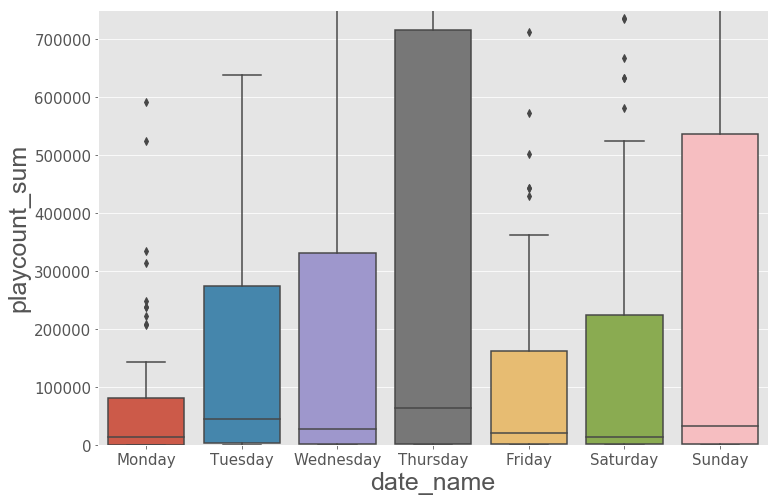

In [181]:
make_boxes(var_y = 'playcount_sum')
plt.ylim(0,750000)

(0, 100000)

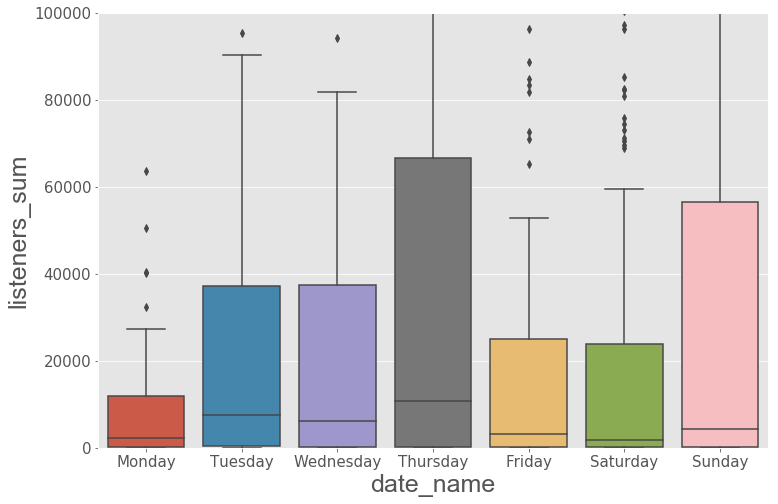

In [185]:
make_boxes(var_y = 'listeners_sum')
plt.ylim(0,100000)

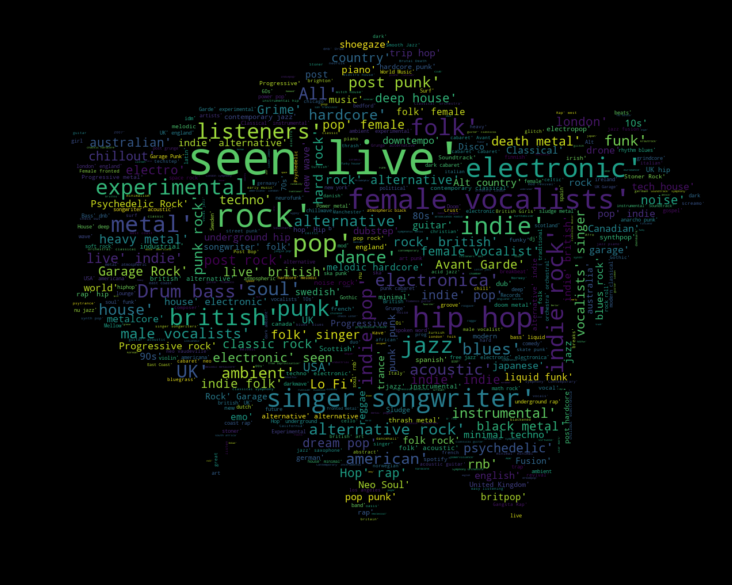

In [161]:
list_of_last_fm_gener = lista_generos(db = events, lib = 'lastfm', var = 'tags')

make_a_Wcloud(lista = list_of_last_fm_gener, mask = "London_mask2.png", n_words = 500)

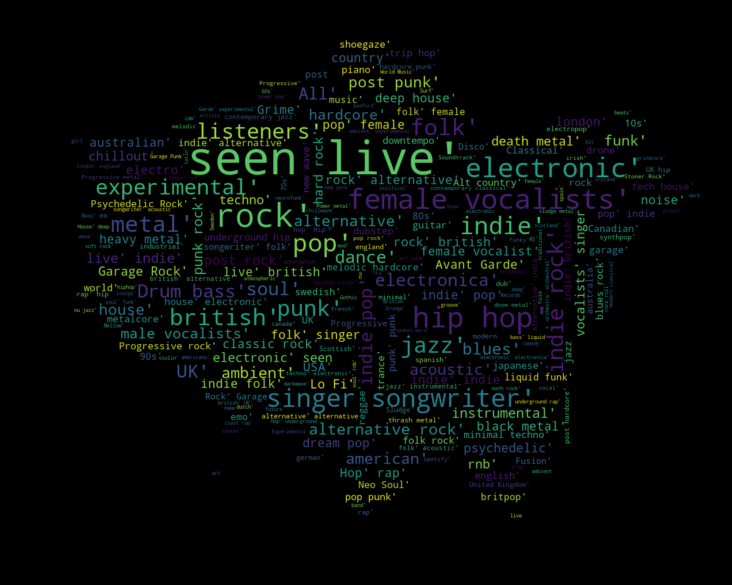

In [162]:
make_a_Wcloud(lista = list_of_last_fm_gener, mask = "London_mask2.png", n_words = 250)

## FourSquare

In [241]:
len(events['foursquare'][0])

12

In [242]:
len(events['foursquare'][1])

12

In [243]:
len(events['foursquare'][2])

12

In [248]:
len(events['foursquare'][23])

13

In [245]:
len(events['foursquare'][4])

11

In [250]:
for keys in events['foursquare'][23]:
    print(keys)

id
name
fq_url
location
price
description
likes
likes_summary
photo
contact
rating
rating_color
tips


In [251]:
events['foursquare'][23]


{'contact': {'facebook': '203878729633687',
  'facebook_name': 'Boisdale Restaurants',
  'facebook_username': 'BoisdaleRestaurants',
  'phone': '+442077155818',
  'twitter': 'boisdalecw',
  'url': 'http://www.boisdale.co.uk'},
 'description': 'A lively restaurant serving traditional Scottish cuisine, with live music, whisky bar, cigar terrace, caviar and oyster bar and cigar library, overlooking the Thames and city skyline.',
 'fq_url': 'http://4sq.com/g14NxC',
 'id': '4da4b31e2538d7ce7bad465c',
 'likes': 122,
 'likes_summary': '122 Likes',
 'location': {'address': 'Cabot Place',
  'city': 'Canary Wharf',
  'zip': 'E14 4QT'},
 'name': 'Boisdale of Canary Wharf',
 'photo': {'prefix': 'https://igx.4sqi.net/img/general/',
  'suffix': '/1420470_G42gIu4Ik0ogLk0THJzmX2GutiGjd6n_LIOk4bhkyaw.jpg'},
 'price': {'currency': '£', 'message': 'Expensive', 'tier': 3},
 'rating': 7.9,
 'rating_color': 'C5DE35',
 'tips': [{'text': 'No mention was made when I booked for dinner that an extra £15 per head

In [270]:
events['foursquare'][23]['price']['tier']

3

In [274]:
lista_nueva = []
# Make this for the desired variable
for i in range(len(events['foursquare'])):

    # If there is nothing in the spotify dictionary, make Nan value
    if type(events['foursquare'][i]) == float:
        lista_nueva.append(np.nan)

    else:
        try:
            #print(db['foursquare'][i]['price']['tier'])
            lista_nueva.append(events['foursquare'][i]['price']['tier'])

        except:
            lista_nueva.append(np.nan)


# Integrate all the stuff
events['tier_price'] =   lista_nueva

In [272]:
def make_vars_1(db = events, dictionary = 'spotify', var = 'popularity_median'):
    lista_nueva = []
    # Make this for the desired variable
    for i in range(len(db[dictionary])):
        
        # If there is nothing in the spotify dictionary, make Nan value
        if type(db[dictionary][i]) == float:
            lista_nueva.append(np.nan)

        else:
            try:
                #print(db[dictionary][i][var])
                lista_nueva.append(db[dictionary][i][var])
                
            except:
                lista_nueva.append(np.nan)
                
            
    # Integrate all the stuff
    db[var] =   lista_nueva      


In [273]:
list_of_4sqrs_vars = ['likes', 'rating']

In [278]:
for i in list_of_4sqrs_vars:
    # print(i)
    make_vars_1(db = events, dictionary = 'foursquare', var = i)

In [95]:
for i in list_of_bars:
    # print(i)
    make_vars(db = events, dictionary = 'spotify', var = i)

In [199]:
len(events)

1556

In [198]:
len(events['foursquare'])

1556

In [234]:
events['foursquare'][0]['description']

'Legendary venue dedicated to nurturing creative young talent and presenting an eclectic line up of  Live Music, Theatre, Circus and New Media.'

In [235]:
def lista_generos_2(db = events, lib = 'spotify', var = 'genres'):
    list_of_strings = []

    for i in range(len(db[lib])):
        #print(i)
        try:
            list_of_strings.append(db[lib][i][var])
            
        except: 
            pass
            
    return(list_of_strings)    


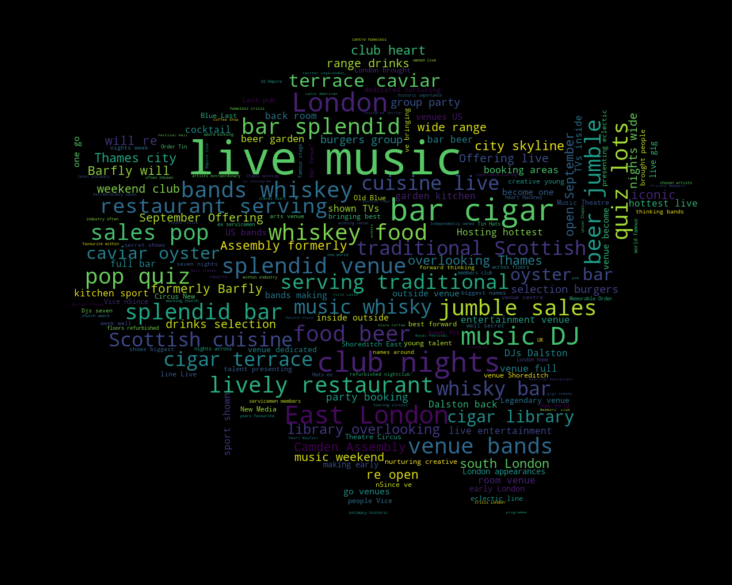

In [237]:
list_of_4sq_descr = lista_generos_2(db = events, lib = 'foursquare', var = 'description')

make_a_Wcloud(lista = list_of_4sq_descr, mask = "London_mask2.png", n_words = 200)

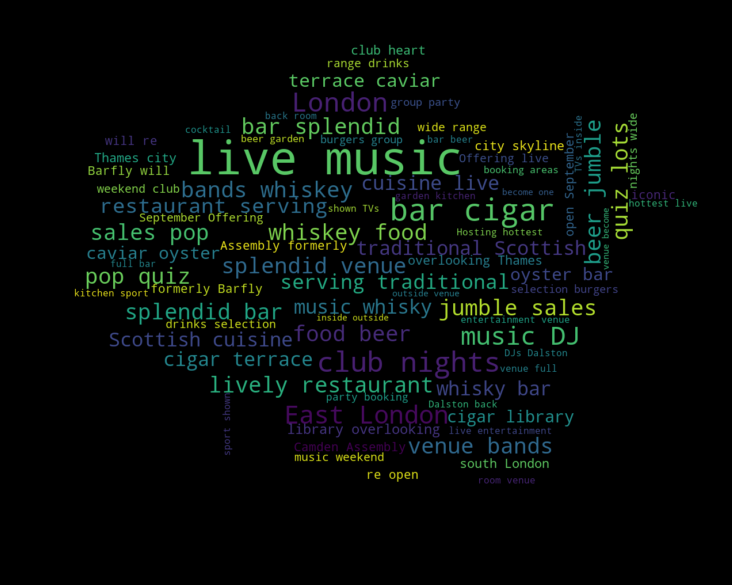

In [238]:
make_a_Wcloud(lista = list_of_4sq_descr, mask = "London_mask2.png", n_words = 80)

(0, 4)

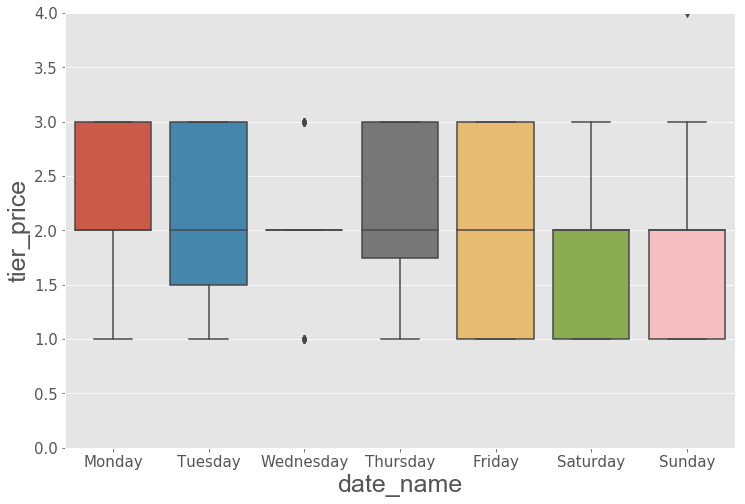

In [277]:
make_boxes(var_y = 'tier_price')
plt.ylim(0,4)

(5, 10)

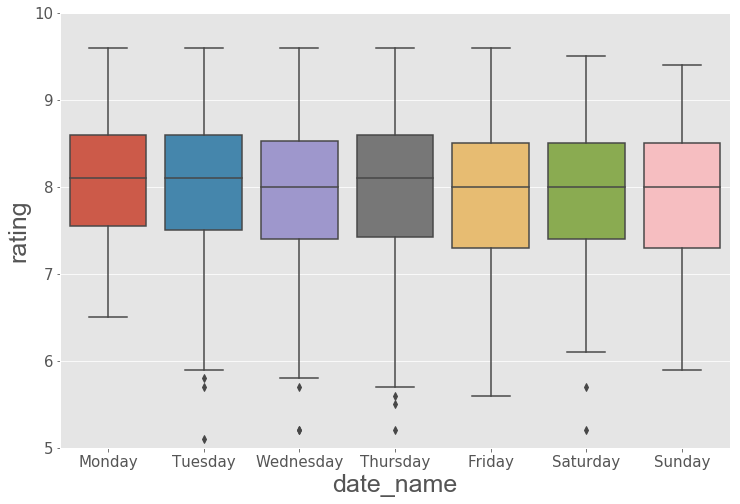

In [296]:
make_boxes(var_y = 'rating')
plt.ylim(5,10)

(0, 500)

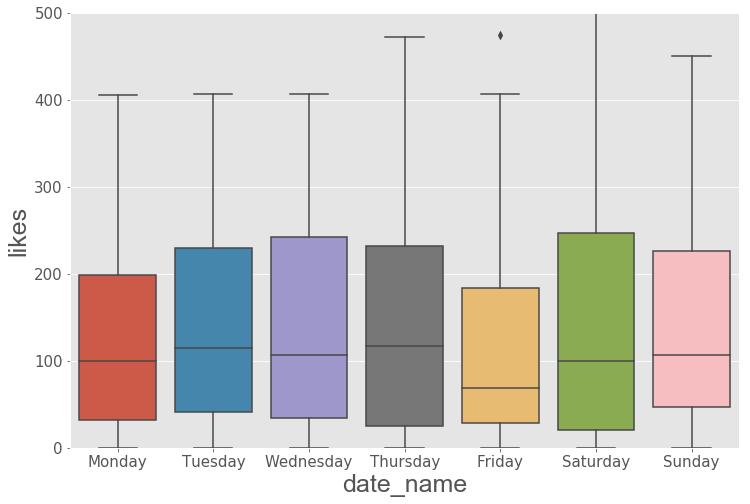

In [292]:
make_boxes(var_y = 'likes')
plt.ylim(0,500)

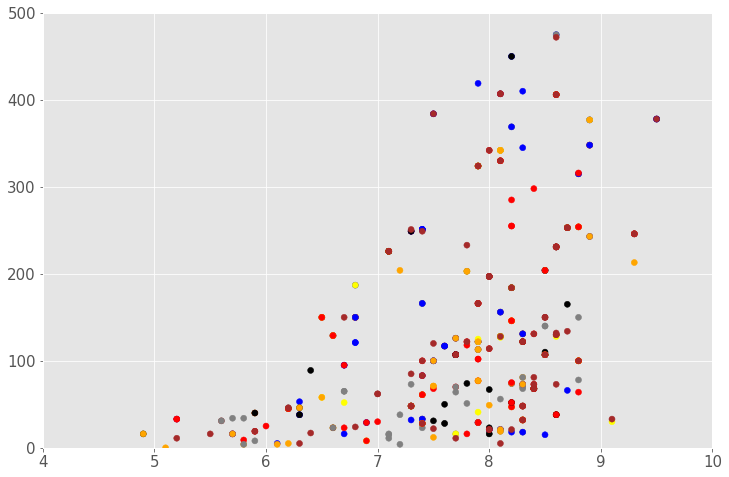

In [305]:
colors = {'Monday':'yellow', 
          'Tuesday':'orange', 
          'Wednesday':'red', 
          'Thursday':'brown', 
          'Friday': 'grey' ,
          'Saturday': 'blue' , 
          'Sunday' : 'black' }

fig, ax = plt.subplots()
ax.scatter(db['rating'], db['likes'], c=db['date_name'].apply(lambda x: colors[x]))

plt.ylim(0,500)
plt.xlim(4,10)
plt.show()

(4, 10)

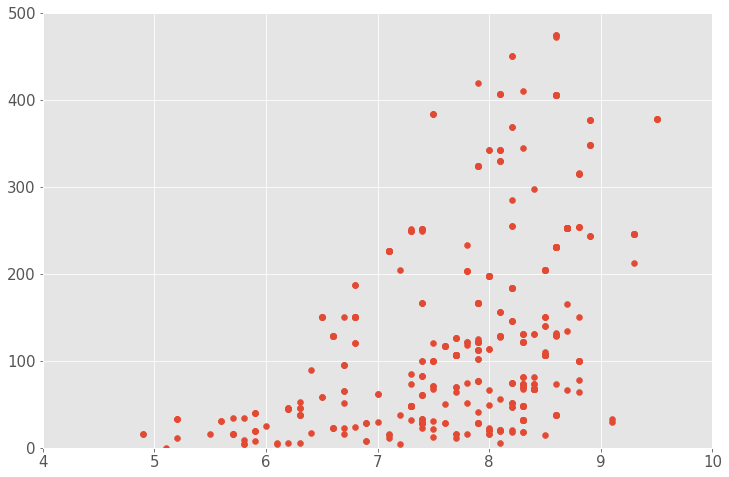

In [302]:
plt.scatter(db['rating'], db['likes'])
plt.ylim(0,500)
plt.xlim(4,10)

## City Level

## Bourogh Level

## Gigs data